In [1]:
from gtda import *
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
aa_properties = {'PHE': [1, 165.19, 147.18, 1.83, 9.13, 5.48 ], 
               'LEU': [0.943, 131.18, 113.16, 2.36, 9.60, 5.98],
               'ILE': [0.943, 131.18, 113.16, 2.36, 9.60, 6.02],
               'TYR': [0.880, 181.19, 163.18, 2.20, 9.11, 5.66], 
               'TRP': [0.878, 204.23, 186.22, 2.83, 9.39, 5.89],
               'VAL': [0.825, 117.15, 99.13, 2.32, 9.62, 5.96],
               'MET': [0.738, 149.21, 131.20, 2.28, 9.21, 5.74],
               'PRO': [0.711, 115.13, 97.12, 1.99, 10.60, 6.30],
               'CYS': [0.680, 121.16, 103.15, 1.96, 10.28, 5.07],
               'ALA': [0.616, 89.10, 71.08, 2.34, 9.69, 6.00],
               'GLY': [0.501, 75.07, 57.05, 2.34, 9.60, 5.97],
               'THR': [0.450, 119.12, 101.11, 2.09, 9.10, 5.60],
               'SER': [0.359, 105.09, 87.08, 2.21, 9.15, 5.68],
               'LYS': [0.283, 146.19, 128.18, 2.18, 8.95, 9.74],
               'GLN': [0.251, 146.15, 128.13, 2.17, 9.13, 5.65],
               'ASN': [0.236, 132.12, 114.11, 2.02, 8.80, 5.41],
               'HIS': [0.165, 155.16, 137.14, 1.82, 9.17, 7.59],
               'GLU': [0.043, 147.13, 129.12, 2.19, 9.67, 3.22],
               'ASP': [0.028, 133.11, 115.09, 1.88, 9.60, 2.77],
               'ARG': [0, 174.20, 156.19, 2.17, 9.04, 10.76]} 
#Values found on https://www.sigmaaldrich.com/life-science/metabolomics/learning-center/amino-acid-reference-chart.html
#and https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/midas/hydrophob.html 

In [3]:
import time

aa3 = "ALA CYS ASP GLU PHE GLY HIS ILE LYS LEU MET ASN PRO GLN ARG SER THR VAL TRP TYR".split()

#Transform aa into onehot
df = pd.read_pickle('protdiag_30.pkl')
df['hydrophobicity'] = df.amino_acid.apply(lambda x: aa_properties[x][0])
df['MolecularWeight'] = df.amino_acid.apply(lambda x: aa_properties[x][1])
df['ResidueWeight'] = df.amino_acid.apply(lambda x: aa_properties[x][2])
df['pKa'] = df.amino_acid.apply(lambda x: aa_properties[x][3])
df['pKb'] = df.amino_acid.apply(lambda x: aa_properties[x][4])
df['pl'] = df.amino_acid.apply(lambda x: aa_properties[x][5])

df.amino_acid = df.amino_acid.astype('category')
df.amino_acid.cat.set_categories(aa3)
df.site = df.site.astype('int')
onehot = pd.get_dummies(df.amino_acid)
df = df.join(onehot)


ind = df.index.unique(level=0)

validation_df = df.loc[ind[4000:4100]]
df = pd.concat((df[df['site'] == 1].iloc[:1000],df[df['site'] == 0].iloc[:1000]))




In [4]:
df[df['site']==1].size/ df.size

0.5

In [5]:
start_time = time.time()
pe = diagrams.PersistenceEntropy(
    normalize=True,
    n_jobs=-1
)

pers_feat = pe.fit_transform(np.stack(df['persistence'].to_numpy()) )

end_time = time.time()
print(end_time - start_time, 's')

df['entropy_0'] = pers_feat[:,0]
df['entropy_1'] = pers_feat[:,1]
df['entropy_2'] = pers_feat[:,2]
del pers_feat


start_time = time.time()
pe = diagrams.PersistenceEntropy(
    normalize=True,
    n_jobs=-1
)

pers_feat = pe.fit_transform(np.stack(validation_df['persistence'].to_numpy()) )

end_time = time.time()
print(end_time - start_time, 's')

validation_df['entropy_0'] = pers_feat[:,0]
validation_df['entropy_1'] = pers_feat[:,1]
validation_df['entropy_2'] = pers_feat[:,2]
del pers_feat

4.529675483703613 s
0.31560301780700684 s


In [6]:
start_time = time.time()
amp1 = diagrams.Amplitude(metric='wasserstein', n_jobs=-1)

amp1_feat = amp1.fit_transform(np.stack(df['persistence'].to_numpy()))

end_time = time.time()
print(end_time - start_time, 's')

df['amp1_0'] = amp1_feat[:, 0]
df['amp1_1'] = amp1_feat[:, 1]
df['amp1_2'] = amp1_feat[:, 2]
del amp1_feat

start_time = time.time()
amp1 = diagrams.Amplitude(metric='wasserstein', n_jobs=-1)

amp1_feat = amp1.fit_transform(np.stack(validation_df['persistence'].to_numpy()))

end_time = time.time()
print(end_time - start_time, 's')

validation_df['amp1_0'] = amp1_feat[:, 0]
validation_df['amp1_1'] = amp1_feat[:, 1]
validation_df['amp1_2'] = amp1_feat[:, 2]
del amp1_feat

0.052678823471069336 s
0.48298192024230957 s


In [7]:
start_time = time.time()

amp2 = diagrams.Amplitude(metric='bottleneck', n_jobs=-1)

amp2_feat = amp2.fit_transform(np.stack(df['persistence'].to_numpy()))

end_time = time.time()
print(end_time - start_time, 's')

df['amp2_0'] = amp2_feat[:, 0]
df['amp2_1'] = amp2_feat[:, 1]
df['amp2_2'] = amp2_feat[:, 2]

del amp2_feat

start_time = time.time()

amp2 = diagrams.Amplitude(metric='bottleneck', n_jobs=-1)

amp2_feat = amp2.fit_transform(np.stack(validation_df['persistence'].to_numpy()))

end_time = time.time()
print(end_time - start_time, 's')

validation_df['amp2_0'] = amp2_feat[:, 0]
validation_df['amp2_1'] = amp2_feat[:, 1]
validation_df['amp2_2'] = amp2_feat[:, 2]

del amp2_feat

0.05884289741516113 s
0.5818626880645752 s


In [8]:
start_time = time.time()

amp3 = diagrams.Amplitude(metric='landscape', n_jobs=-1)


amp3_feat = amp3.fit_transform(np.stack(df['persistence'].to_numpy()))

end_time = time.time()
print(end_time - start_time, 's')

df['amp3_0'] = amp3_feat[:, 0]
df['amp3_1'] = amp3_feat[:, 1]
df['amp3_2'] = amp3_feat[:, 2]

del amp3_feat

start_time = time.time()

amp3 = diagrams.Amplitude(metric='landscape', n_jobs=-1)


amp3_feat = amp3.fit_transform(np.stack(validation_df['persistence'].to_numpy()))

end_time = time.time()
print(end_time - start_time, 's')

validation_df['amp3_0'] = amp3_feat[:, 0]
validation_df['amp3_1'] = amp3_feat[:, 1]
validation_df['amp3_2'] = amp3_feat[:, 2]

del amp3_feat

0.07872724533081055 s
1.246063470840454 s


In [9]:
start_time = time.time()

amp4 = diagrams.Amplitude(metric='betti', n_jobs=-1)

amp4_feat = amp4.fit_transform(np.stack(df['persistence'].to_numpy()))


end_time = time.time()
print(end_time - start_time, 's')

df['amp4_0'] = amp4_feat[:, 0]
df['amp4_1'] = amp4_feat[:, 1]
df['amp4_2'] = amp4_feat[:, 2]

del amp4

start_time = time.time()

amp4 = diagrams.Amplitude(metric='betti', n_jobs=-1)

amp4_feat = amp4.fit_transform(np.stack(validation_df['persistence'].to_numpy()))


end_time = time.time()
print(end_time - start_time, 's')

validation_df['amp4_0'] = amp4_feat[:, 0]
validation_df['amp4_1'] = amp4_feat[:, 1]
validation_df['amp4_2'] = amp4_feat[:, 2]

del amp4

0.05902433395385742 s
0.6394908428192139 s


In [10]:
start_time = time.time()

pnts = diagrams.NumberOfPoints( n_jobs=-1)

pnts_feat = pnts.fit_transform(np.stack(df['persistence'].to_numpy()))


end_time = time.time()
print(end_time - start_time, 's')

df['pnts_0'] = pnts_feat[:, 0]
df['pnts_1'] = pnts_feat[:, 1]
df['pnts_2'] = pnts_feat[:, 2]

del pnts

start_time = time.time()

pnts = diagrams.NumberOfPoints( n_jobs=-1)

pnts_feat = pnts.fit_transform(np.stack(validation_df['persistence'].to_numpy()))


end_time = time.time()
print(end_time - start_time, 's')

validation_df['pnts_0'] = pnts_feat[:, 0]
validation_df['pnts_1'] = pnts_feat[:, 1]
validation_df['pnts_2'] = pnts_feat[:, 2]

del pnts

0.08218741416931152 s
1.3183023929595947 s


In [27]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

features = ['hydrophobicity',
            'entropy_0', 'entropy_1', 'entropy_2',
            'amp1_0','amp1_1', 'amp1_2',
            'amp2_0','amp2_1', 'amp2_2',
            'amp3_0','amp3_1', 'amp3_2',
            'amp4_0','amp4_1', 'amp4_2',
            'pnts_0', 'pnts_1', 'pnts_2', 'MolecularWeight', 'ResidueWeight', 'pKa', 'pKb', 'pl'] + aa3



X = df[features].values
Y = df['site'].values

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.20, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [28]:

from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


#classifier = LinearSVC()
#classifier = SVC(max_iter=10000, probability=True)

#Random forest
#classifier =  RandomForestClassifier(max_depth=1000, random_state=0)

#K-nearest neghbour
#classifier = KNeighborsClassifier(n_neighbors=1000)

#Naive Bayes
from sklearn.naive_bayes import GaussianNB
#classifier = GaussianNB()


from sklearn.ensemble import AdaBoostClassifier
#classifier = AdaBoostClassifier(n_estimators=100, random_state=0)

from sklearn.ensemble import GradientBoostingClassifier
#classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

from sklearn.ensemble import BaggingClassifier
classifier = BaggingClassifier(base_estimator=SVC(),n_estimators=10, random_state=0)

In [29]:
start = time.time()




classifier.fit(X_train, Y_train)
end = time.time()

print(end - start)

0.620685338973999


In [30]:
(classifier.predict(X_test) == Y_test).mean()

0.6625

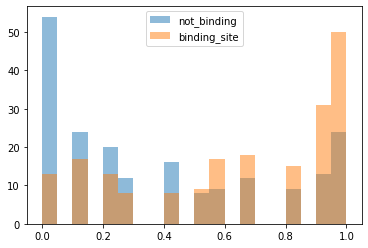

In [31]:
from matplotlib import pyplot as plt

plt.hist(classifier.predict_proba(X_test[Y_test==0])[:, 1], bins=20, alpha=0.5, label='not_binding')

plt.hist(classifier.predict_proba(X_test[Y_test==1])[:,1], bins=20, alpha=0.5, label='binding_site')

plt.legend()

In [32]:
validation_df['old_prob'] = classifier.predict_proba(scaler.transform(validation_df[features].values))[:, 1]


In [33]:
results = validation_df[['site', 'old_prob']]
results['pred'] = (results.loc[:,'old_prob'] > 0.5).apply(lambda x : int(x))

precision = (results[results.pred == 1]['pred'] == results[results.pred == 1]['site']).mean()

recall = (results[results.site == 1]['pred'] == results[results.site == 1]['site']).mean()


precision, recall

/home/maths/phufwh/myenv/lib64/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0.11723440936924083, 0.5818825612275007)

In [34]:
newvalidation_df = pd.DataFrame()
def smooth(res):

    center = small_test.loc[res, ['x', 'y', 'z']].to_numpy()
    small_test['weight'] = np.exp(-((small_test.loc[:,'x'] - center[0])**2 + (small_test.loc[:,'y'] - center[1])**2 + (small_test.loc[:, 'z'] - center[2])**2) / 30)
    return (small_test['weight']*small_test['old_prob']).sum()/(small_test['weight'].to_numpy().sum())
    

for prot in tqdm(validation_df.index.unique(level=0)):
    small_test= validation_df.loc[prot]    
    small_test['new_prob'] = small_test.loc[:,'res_num'].apply(smooth)
    newvalidation_df = newvalidation_df.append(small_test)

  0%|          | 0/100 [00:00<?, ?it/s]/home/maths/phufwh/myenv/lib64/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/maths/phufwh/myenv/lib64/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


In [35]:
results = newvalidation_df[['site', 'new_prob']]
results['pred'] = (results.loc[:,'new_prob'] > 0.5).apply(lambda x : int(x))

precision = (results[results.pred == 1]['pred'] == results[results.pred == 1]['site']).mean()

recall = (results[results.site == 1]['pred'] == results[results.site == 1]['site']).mean()


precision, recall

/home/maths/phufwh/myenv/lib64/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0.1289541918755402, 0.6603717910888167)

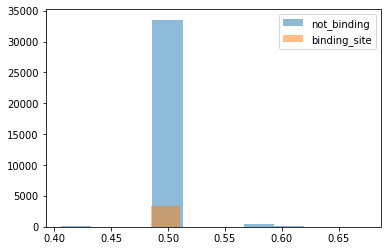

In [20]:
from matplotlib import pyplot as plt

plt.hist(validation_df[validation_df['site'] == 0]['old_prob'], bins=10, alpha=0.5, label='not_binding')

plt.hist(validation_df[validation_df['site'] == 1]['old_prob'], bins=10, alpha=0.5, label='binding_site')

plt.legend()

0.5012502137957638
0.5016323322664268


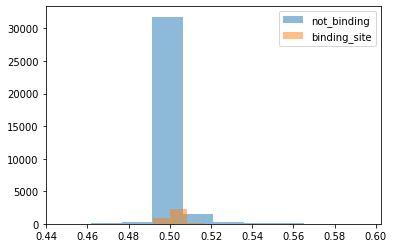

In [21]:
from matplotlib import pyplot as plt

a = newvalidation_df[newvalidation_df['site'] == 0]['new_prob']
print(a.mean())
b = newvalidation_df[newvalidation_df['site'] == 1]['new_prob']
print(b.mean())
plt.hist(newvalidation_df[newvalidation_df['site'] == 0]['new_prob'], bins=10, alpha=0.5, label='not_binding')
plt.hist(newvalidation_df[newvalidation_df['site'] == 1]['new_prob'], bins=10, alpha=0.5, label='binding_site')

plt.legend()

